<a href="https://colab.research.google.com/github/Farzaneh-Abedini/Farzaneh-Abedini/blob/main/earthquake_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:


# @title Load our modules from repository.
# @markdown This block brings the libraries from the Github repository and make
# @markdown it available in this colab.
import getpass
import os
import sys

from IPython.display import clear_output

git_token = getpass.getpass('Enter your Github personal token:')

current_dir = os.getcwd()
# Clone repository and install requirements
!git clone https://$git_token@github.com/Farzaneh-Abedini/Fragility-curves.git
sys.path.append(current_dir+'/Fragility_curves')


Enter your Github personal token:··········
fatal: destination path 'Fragility-curves' already exists and is not an empty directory.


# Analysis

Now let's put everything toghether. First we load the data, we then use our models defined above fit model calculate probabilities and all other good things.

In [17]:
#@title Load input data
#@markdown Make sure to upload the data file, all the files will disappear when the kernel disconnects.
input_file = "final_results_5.csv" # @param {type:"string"}
import pandas as pd

df = pd.read_csv(input_file)

#@markdown Open this block to edit the names of the measures.
measures = ['acceleration_AI', 'acceleration_CAV', 'acceleration_SA', 'acceleration_max', 'velocity_max', 'displacement_max']
damages = ['LEFT-TUNNEL_max_damage_index', 'RIGHT-TUNNEL_max_damage_index', 'ROOF-TUNNEL_max_damage_index', 'BOTTOM-TUNNEL_max_damage_index']
all_di_name = 'TUNNEL_max_damage_index'
df[all_di_name] = df[damages].max(axis=1)

damage_titles = {
  all_di_name: 'All Sides',
  'LEFT-TUNNEL_max_damage_index': 'Left Column',
  'RIGHT-TUNNEL_max_damage_index': 'Right Column',
  'ROOF-TUNNEL_max_damage_index': 'Roof',
  'BOTTOM-TUNNEL_max_damage_index': 'Deck'
}

measure_titles = {
    'acceleration_AI': 'AI',
    'acceleration_CAV': 'CAV (m/s)',
    'acceleration_SA': 'SA (g)',
    'acceleration_max': 'PGA (g)',
    'velocity_max': 'PGV (m/s)',
    'displacement_max':'PGD (m)',
}

damage_name_map = {name:col for col, name in damage_titles.items()}
measure_name_map = {name:col for col, name in measure_titles.items()}

damage_names = [damage_titles[damage] for damage in damage_titles]
measure_names = [measure_titles[measure] for measure in measures]


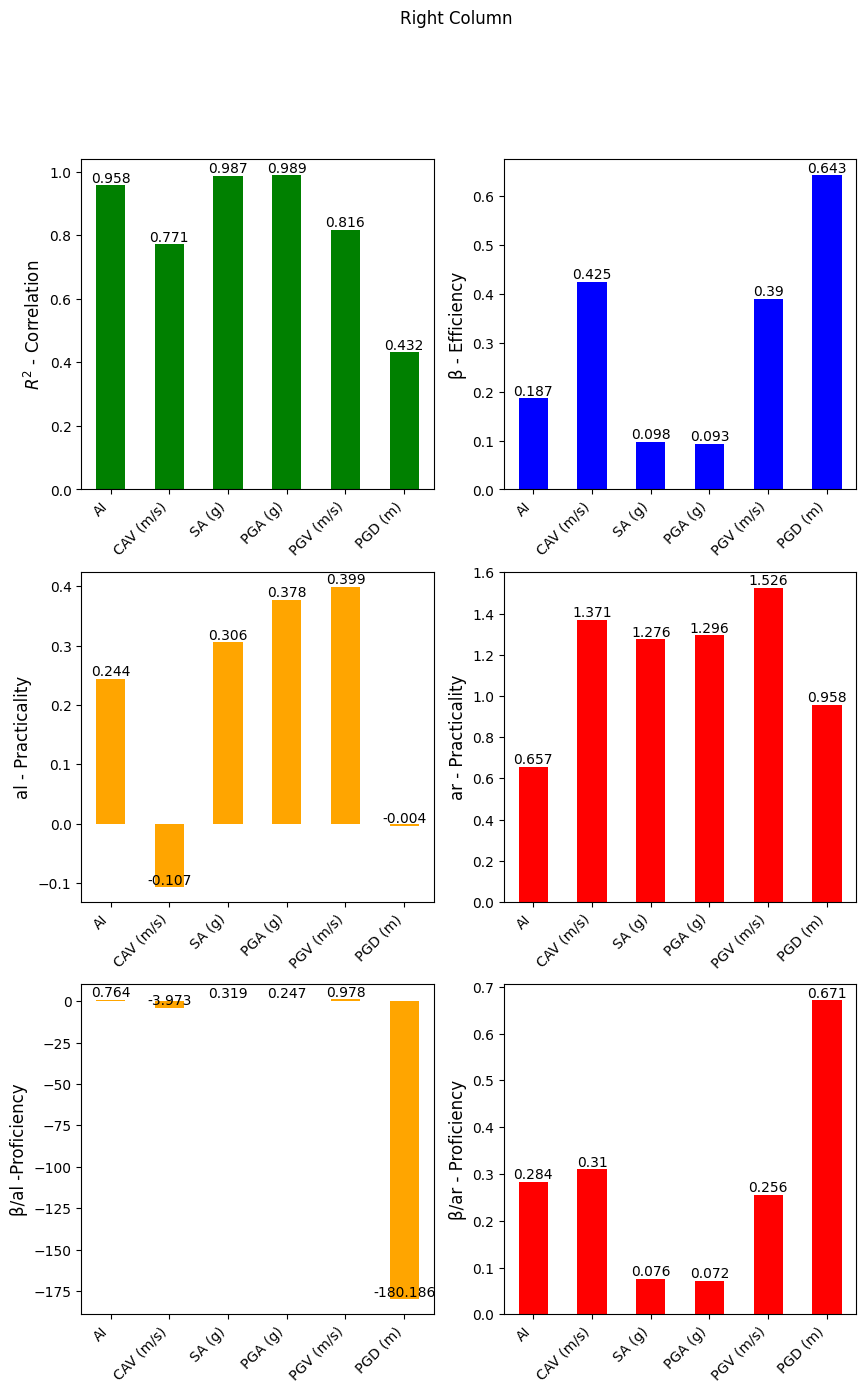

In [18]:

# @title Plotting All Measures
# @markdown Here we plot all measures for the damage on all or each side of the
# @markdown tunnel. We then pick one of the measures that seems to have the best
# @markdown fit as the basis for the secondary analysis.
# @markdown Select the side of the tunnel that you want to perform analysis on:
damage_name = 'Right Column' # @param ['All Sides', 'Left Column', 'Right Column', 'Roof', 'Deck']
# @markdown We model the damage vs. different measures. What family of the
# @markdown models should be used for fitting that data.
model_type = 'Continous piecewise linear' # @param ['Linear', 'Continous piecewise linear']
# @markdown Analysis are going to be in a logarithmic scale, please select the
# @markdown base for the logarithmic analysis.
base_name = 'e' # @param ['e', '10']

from Fragility_curves.psdm import psdm
import numpy as np
import matplotlib.pyplot as plt

model_name_mapping = {
    'Continous piecewise linear': psdm.PiecewiseLinearModel,
    'Linear': psdm.SimpleLinearModel,
}
ModelClass = model_name_mapping[model_type]

log_name_mapping = {
    'e': (np.e, np.log),
    '10': (10, np.log10),
}

#log_fn is a function for the logarithm, explained above
base, log_fn = log_name_mapping[base_name]

damage_col = damage_name_map[damage_name]

y = log_fn(df[damage_col])

all_models = {}
# let's fit model for all the measures
for m in measures:
  x_m = log_fn(df[m])
  # We plot for one damage.
  model = ModelClass()
  model.fit(x_m, y)
  all_models[m] = model

#standard deviation from the psdm and regression lines.

results = {}
for m in measures:
  x_m = log_fn(df[m])
  # We plot for one damage.
  y_true = y
  model = all_models[m]
  y_pred = model.predict(x_m)
  y_pred_std = model.std(x_m)
  ss_res = np.sum((y_true - y_pred) ** 2)
  # Calculate the total sum of squares
  ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
  # Calculate R-squared
  r_squared = 1 - (ss_res / ss_tot)

  if model_type=='Continous piecewise linear' :
   sl=model.best_model.coeffs_left.slope
   sr=model.best_model.coeffs_right.slope
   results[m] = {'std': y_pred_std.mean(),
                 'stdr':model.best_model.coeffs_right.std,
                 'stdl':model.best_model.coeffs_left.std,
              'r2': r_squared,
              'br': sr,
              'bl': sl,
              'stdr/br': y_pred_std.mean()/sr,
              'stdl/bl': y_pred_std.mean()/sl }

  elif model_type== 'Linear':
   s=model.coeffs.slope
   results[m] = {'std': y_pred_std.mean(),
             'r2': r_squared,
              'Slope': s,
              'std/b': y_pred_std.mean()/s }
results_df = pd.DataFrame(results).T
# Plotting
###################
if model_type=='Continous piecewise linear':
  fig, ((ax_r2, ax_std), (ax_slope_l, ax_slope_r),(ax_stdb_l, ax_stdb_r)) = plt.subplots(3, 2, figsize=(10, 15))
  plt.subplots_adjust(hspace=0.25, wspace=0.2)


  results_df['r2'].plot(kind='bar', ax=ax_r2, color='green')
  ax_r2.set_ylabel('$R^2$ - Correlation', fontsize=12)
  ax_r2.set_xticklabels(measure_names, rotation=45, ha = 'right')
  for i, v in enumerate(results_df["r2"]):
    ax_r2.text(i, v, str(round(v, 3)), ha='center', va='bottom', fontsize=10)

# Plot the second column in the second subplot
  results_df["std"].plot(kind='bar', ax=ax_std, color='blue')
  ax_std.set_ylabel('β - Efficiency', fontsize=12)
  ax_std.set_xticklabels(measure_names, rotation=45, ha = 'right')
  for i, v in enumerate(results_df["std"]):
    ax_std.text(i, v, str(round(v, 3)), ha='center', va='bottom', fontsize=10)


  results_df["bl"].plot(kind='bar', ax=ax_slope_l, color='orange')
  ax_slope_l.set_ylabel('al - Practicality', fontsize=12)
  ax_slope_l.set_xticklabels(measure_names, rotation=45, ha = 'right')
  for i, v in enumerate(results_df["bl"]):
    ax_slope_l.text(i, v, str(round(v, 3)), ha='center', va='bottom', fontsize=10)


  results_df["br"].plot(kind='bar', ax=ax_slope_r, color='red')
  ax_slope_r.set_ylabel('ar - Practicality', fontsize=12)
  ax_slope_r.set_xticklabels(measure_names, rotation=45, ha = 'right')
  for i, v in enumerate(results_df["br"]):
    ax_slope_r.text(i, v, str(round(v, 3)), ha='center', va='bottom', fontsize=10)


  results_df["stdr/br"].plot(kind='bar', ax=ax_stdb_r, color='red')
  ax_stdb_r.set_ylabel('β/ar - Proficiency', fontsize=12)
  ax_stdb_r.set_xticklabels(measure_names, rotation=45, ha = 'right')
  for i, v in enumerate(results_df["stdr/br"]):
    ax_stdb_r.text(i, v, str(round(v, 3)), ha='center', va='bottom', fontsize=10)

  results_df["stdl/bl"].plot(kind='bar', ax=ax_stdb_l, color='orange')
  ax_stdb_l.set_ylabel('β/al -Proficiency', fontsize=12)
  ax_stdb_l.set_xticklabels(measure_names, rotation=45, ha = 'right')
  for i, v in enumerate(results_df["stdl/bl"]):
    ax_stdb_l.text(i, v, str(round(v, 3)), ha='center', va='bottom', fontsize=10)


#################
if model_type== 'Linear':
  fig, ((ax_r2, ax_std), (ax_slope, ax_std_b)) = plt.subplots(2, 2, figsize=(12, 8))
  plt.subplots_adjust(hspace=0.25, wspace=0.2)

  # Now plot your data as before

  results_df['r2'].plot(kind='bar', ax=ax_r2, color='green')
  ax_r2.set_ylabel('$R^2$ - Correlation', fontsize=12)
  ax_r2.set_xticks(np.arange(len(measure_names)))
  ax_r2.set_xticklabels(measure_names, rotation=45, ha = 'right')
  for i, v in enumerate(results_df["r2"]):
    ax_r2.text(i, v, str(round(v, 3)), ha='center', va='bottom', fontsize=10)


# Plot the second column in the second subplot
  results_df["std"].plot(kind='bar', ax=ax_std, color='blue')
  ax_std.set_ylabel('β - Efficiency', fontsize=12)
  ax_std.set_xticks(np.arange(len(measure_names)))
  ax_std.set_xticklabels(measure_names, rotation=45, ha = 'right')
  for i, v in enumerate(results_df["std"]):
      ax_std.text(i, v, str(round(v, 3)), ha='center', va='bottom', fontsize=10)


  # Plot the third column in the second subplot
  results_df["Slope"].plot(kind='bar', ax=ax_slope, color='red')
  ax_slope.set_ylabel('a - Practicality', fontsize=12)
  ax_slope.set_xticks(np.arange(len(measure_names)))
  ax_slope.set_xticklabels(measure_names, rotation=45, ha = 'right')
  for i, v in enumerate(results_df["Slope"]):
    ax_slope.text(i, v, str(round(v, 3)), ha='center', va='bottom', fontsize=10)


  # Plot the fourth column in the second subplot
  results_df["std/b"].plot(kind='bar', ax=ax_std_b, color='orange')
  ax_std_b.set_ylabel('β/a - proficiency', fontsize=12)
  ax_std_b.set_xticks(np.arange(len(measure_names)))
  ax_std_b.set_xticklabels(measure_names, rotation=45, ha = 'right')
  for i, v in enumerate(results_df["std/b"]):
    ax_std_b.text(i, v, str(round(v, 3)), ha='center', va='bottom', fontsize=10)

fig.suptitle(damage_name)
plt.show()

In [19]:
#@title Modeling Damage vs. a Measure
# @markdown Select the side of the tunnel that you want to perform analysis on.

# @markdown Tunnel parts can be analyzed separately or tunnel can be considered as a whole
damage_name = 'Right Column' # @param ['All Sides', 'Left Column', 'Right Column', 'Roof', 'Deck']
# @markdown Please select a measure name you want to perform the analysis on.

# @markdown Measures are calculated on the soil/rock surface

# @markdown  AI: Arias Intensity

# @markdown AI Formula: $(\pi$/2g)$\int$ $a(t)^2 dt$

# @markdown  CAV: Cumulative Absolute Velocity

# @markdown CAV Formula: $\int$$|a(t)| dt$

# @markdown  SA: Spectral Accleration ; Solving with Newmark Method

# @markdown PGA: Peak Ground Acceleration

# @markdown PGV: Peak Ground Velocity

# @markdown PGD: Peak Ground Displacement
measure_name = 'PGA (g)'  # @param [' AI', 'CAV (m/s)', ' SA (g)', 'PGA (g)', 'PGV (m/s)', 'PGD (m)']

# @markdown Damage index is defined as M/Mcapacity

# @markdown Please enter the limits  for damage states as comma separated values.
# @markdown
damage_cutoffs_values = '1.25, 2, 3' # @param {type: "string"}
# @markdown Please enter the name of the intervals as comma separated values,
# @markdown should have the same length as damage_cutoffs_values.
interval_names = 'Minor, Moderate, Extensive' # @param {type: "string"}

from Fragility_curves.psdm import plot
from Fragility_curves.fragility_curve import fragility
from scipy.stats import norm
import matplotlib.pyplot as plt


# The code below is kind of like when we parsed input from `main.py` before.
# It uses the input from user and convert it to the values that are usable by code.
measure_col = measure_name_map[measure_name]

damage_cutoffs = [float(id.strip()) for id in damage_cutoffs_values.split(',')]
damage_cutoffs = sorted(damage_cutoffs)


# Let's make the labels of the cutoffs nice
def _generate_interval_names(cutoffs):
    intervals = []
    # Handle the first interval
    intervals.append(f"(-inf, {cutoffs[0]})")
    # Handle the middle intervals
    for i in range(len(cutoffs)-1):
        intervals.append(f"[{cutoffs[i]}, {cutoffs[i+1]})")
    # Handle the last interval
    intervals.append(f"[{cutoffs[-1]}, inf)")
    return intervals

if not interval_names:
  interval_names = _generate_interval_names(damage_cutoffs)
else:
  interval_names = [co.strip() for co in interval_names.split(',')]

assert len(interval_names) == len(damage_cutoffs)


# Now we have the actual variables that are going to be used ready.
# Let's do the calculations:

x = log_fn(df[measure_col])
y = log_fn(df[damage_col])

log_damage_cutoffs = [log_fn(co) for co in damage_cutoffs]

# Note we dont care what is the underlying model class :-)
model = ModelClass()
model.fit(x, y)

# We create xx, which is in the same range as x but uniform. We go a bit wider
# to make plots nicer.
xx = np.linspace(min(x)-2, max(x)+0.1, 10000)

pp_damage = fragility.damage_probability(model, xx, log_damage_cutoffs)
###
mean_prob, std_prob = fragility.fit_normal_to_probabilities(pp_damage)

pp_fit=fragility.probability_of_intervals_fit(mean_prob, std_prob, log_damage_cutoffs)
# all the calculations are done.
# Now we just plot:

fig, (top_ax, bot_ax) = plt.subplots(2, 1, figsize=(10, 10), sharex = False, gridspec_kw={'height_ratios': [3, 1]})

# Top plot is the data and the fitted model
top_ax.scatter(x, y, label='Original data',color='black')

plot.plot_model_at(top_ax, xx, model, model_name=model_type, kw_plot={'color': 'black'})

values_list = damage_cutoffs_values.split(',')
value1 = float(values_list[0].strip())
value2 = float(values_list[1].strip())
value3 = float(values_list[2].strip())

top_ax.fill_between(xx, log_fn(0.005), log_fn(value1), color='green', alpha=0.3)
top_ax.fill_between(xx, log_fn(value1), log_fn(value2), color='yellow', alpha=0.3)
top_ax.fill_between(xx, log_fn(value2), log_fn(value3), color='orange', alpha=0.3)
top_ax.fill_between(xx, log_fn(value3), log_fn(5), color='red', alpha=0.3)

#plot.make_ticks_log_scale(top_ax, x_axis=True, y_axis=True, base=base, base_name=base_name)

if base_name =='10':
  top_ax.set_xlabel('Log' + measure_name, fontsize=12)
  top_ax.set_ylabel('Log'+ " ( Damage Index (M/Mcapacity) )" , fontsize=12)
else:
  top_ax.set_xlabel('Ln' + measure_name, fontsize=12)
  top_ax.set_ylabel('Ln'+ " ( Damage Index (M/Mcapacity) )" , fontsize=12)


# Bottom plot is the probability of being in each cutoff
# Calculate the probability of a Gausian to be within each cutoff.
#plot.make_ticks_log_scale(bot_ax, x_axis=True, y_axis=False, base=base, base_name=base_name)

if base_name =='10':
  bot_ax.plot(10**xx, pp_damage)
  bot_ax.set_xlabel(measure_name)
else:
  bot_ax.plot(np.exp(xx), pp_damage)
  bot_ax.set_xlabel(measure_name)

if base_name == '10':
    bot_ax.plot(10**xx, pp_fit, 'r-', label='Fitted Normal Distribution')
    bot_ax.set_xlabel('Log' + measure_name, fontsize=12)
else:
    bot_ax.plot(np.exp(xx), pp_fit, 'r-', label='Fitted Normal Distribution')
    bot_ax.set_xlabel('Ln' + measure_name, fontsize=12)

bot_ax.set_ylabel("Probability of Damage", fontsize=12)
bot_ax.legend(interval_names)
bot_ax.set_ylim((0, 1))

fig.suptitle(damage_name)
plt.show()

AttributeError: module 'Fragility_curves.fragility_curve.fragility' has no attribute 'probability_of_intervals_fit'

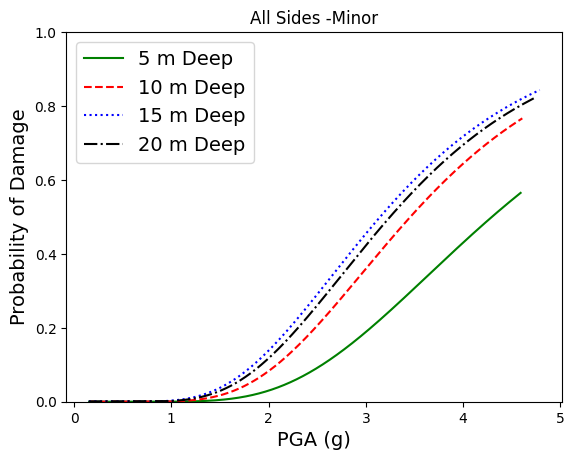

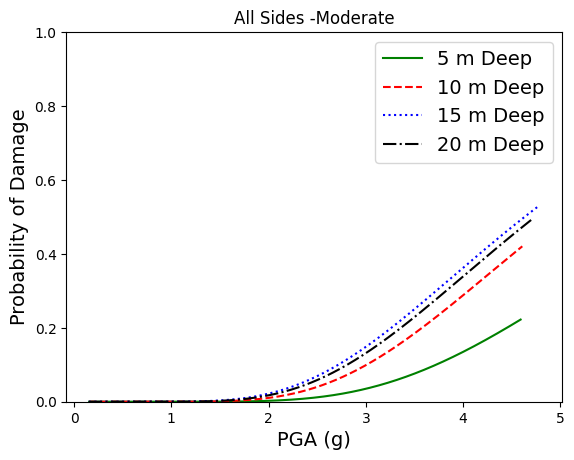

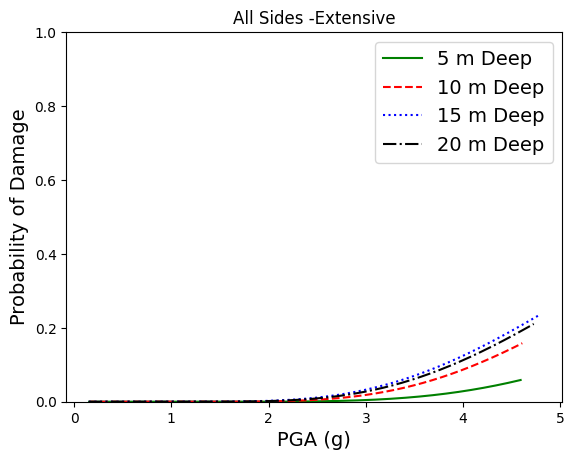

In [ ]:
from Fragility_curves.psdm import plot
from Fragility_curves.fragility_curve import fragility
import matplotlib.pyplot as plt

import pandas as pd

measure_name = 'PGA (g)'  # @param [' AI', 'CAV (m/s)', ' SA (g)', 'PGA (g)', 'PGV (m/s)', 'PGD (m)']

# @markdown Please enter the limits  for damage states as comma separated values.
# @markdown
damage_cutoffs_values = '1.25, 2, 3' # @param {type: "string"}
# @markdown Please enter the name of the intervals as comma separated values,
# @markdown should have the same length as damage_cutoffs_values.
interval_names = 'Minor, Moderate, Extensive' # @param {type: "string"}

#@title Load input data
#@markdown Make sure to upload the data file, all the files will disappear when the kernel disconnects.
input_files = ["final_results_5.csv","final_results_10.csv","final_results_15.csv","final_results_20.csv"]

# @title Plotting All Measures
# @markdown Here we plot all measures for the damage on all or each side of the
# @markdown tunnel. We then pick one of the measures that seems to have the best
# @markdown fit as the basis for the secondary analysis.
# @markdown Select the side of the tunnel that you want to perform analysis on:
damage_name = 'Right Column' # @param ['All Sides', 'Left Column', 'Right Column', 'Roof', 'Deck']
# @markdown We model the damage vs. different measures. What family of the
# @markdown models should be used for fitting that data.
model_type = 'Continous piecewise linear' # @param ['Linear', 'Continous piecewise linear']
# @markdown Analysis are going to be in a logarithmic scale, please select the
# @markdown base for the logarithmic analysis.
base_name = 'e' # @param ['e', '10']

#@markdown Open this block to edit the names of the measures.
measures = ['acceleration_AI', 'acceleration_CAV', 'acceleration_SA', 'acceleration_max', 'velocity_max', 'displacement_max']
damages = ['LEFT-TUNNEL_max_damage_index', 'RIGHT-TUNNEL_max_damage_index', 'ROOF-TUNNEL_max_damage_index', 'BOTTOM-TUNNEL_max_damage_index']
all_di_name = 'TUNNEL_max_damage_index'

linestyles_graph=['solid','dashed','dotted','dashdot']
colors=['green', 'red', 'blue', 'black']
labels=['5 m Deep', '10 m Deep', '15 m Deep', '20 m Deep']
DS=[' -Minor', ' -Moderate', ' -Extensive']

for j in range(3):
  i=0;
  for input_file in input_files:
      df = pd.read_csv(input_file)
      df[all_di_name] = df[damages].max(axis=1)

      damage_titles = {
        all_di_name: 'All Sides',
        'LEFT-TUNNEL_max_damage_index': 'Left Column',
        'RIGHT-TUNNEL_max_damage_index': 'Right Column',
        'ROOF-TUNNEL_max_damage_index': 'Roof',
        'BOTTOM-TUNNEL_max_damage_index': 'Deck'
      }

      measure_titles = {
          'acceleration_AI': 'AI',
          'acceleration_CAV': 'CAV (m/s)',
          'acceleration_SA': 'SA (g)',
          'acceleration_max': 'PGA (g)',
          'velocity_max': 'PGV (m/s)',
          'displacement_max':'PGD (m)',
      }

      damage_name_map = {name:col for col, name in damage_titles.items()}
      measure_name_map = {name:col for col, name in measure_titles.items()}

      damage_names = [damage_titles[damage] for damage in damage_titles]
      measure_names = [measure_titles[measure] for measure in measures]


      model_name_mapping = {
      'Continous piecewise linear': psdm.PiecewiseLinearModel,
      'Linear': psdm.SimpleLinearModel,}

      ModelClass = model_name_mapping[model_type]

      log_name_mapping = {
      'e': (np.e, np.log),
      '10': (10, np.log10),}

      #log_fn is a function for the logarithm, explained above
      base, log_fn = log_name_mapping[base_name]

      damage_col = damage_name_map[damage_name]

      measure_col = measure_name_map[measure_name]

      x = log_fn(df[measure_col])
      y = log_fn(df[damage_col])

      log_damage_cutoffs = [log_fn(co) for co in damage_cutoffs]
      # Note we dont care what is the underlying model class :-)
      model = ModelClass()
      model.fit(x, y)

        # We create xx, which is in the same range as x but uniform. We go a bit wider
        # to make plots nicer.
      xx = np.linspace(min(x) - 0.2, max(x) + 0.2, 10000)

      pp_damage = fragility.damage_probability(model, xx, log_damage_cutoffs[j])

      values_list = damage_cutoffs_values.split(',')
      value1 = float(values_list[0].strip())
      value2 = float(values_list[1].strip())
      value3 = float(values_list[2].strip())

      if base_name == '10':
          plt.plot(10 ** xx, pp_damage, color=colors[i], linestyle=linestyles_graph[i], label=labels[i])
          plt.xlabel(measure_name,fontsize=14)
      else:
          plt.plot(np.exp(xx), pp_damage, color=colors[i], linestyle=linestyles_graph[i],label=labels[i])
          plt.xlabel(measure_name,fontsize=14)

      plt.ylabel("Probability of Damage", fontsize=14)
      plt.legend(fontsize=14)
      plt.ylim((0, 1))

      plt.title(damage_name + DS[j])
      i+=1
  plt.show()



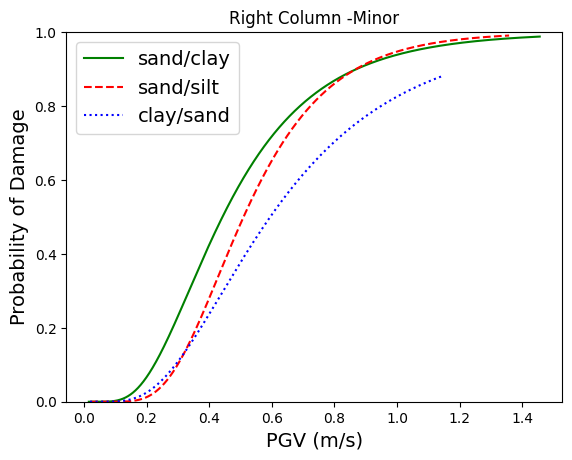

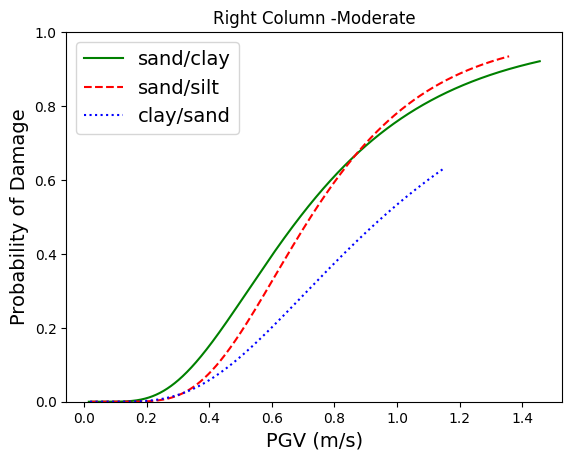

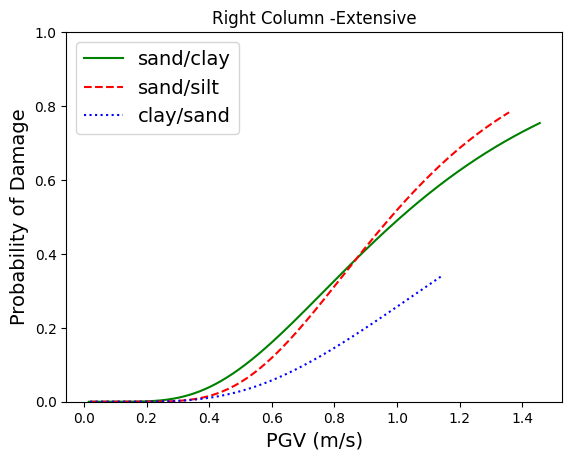

In [ ]:
from Fragility_curves.psdm import plot
from Fragility_curves.fragility_curve import fragility
import matplotlib.pyplot as plt
import pandas as pd

measure_name = 'PGV (m/s)'  # @param [' AI', 'CAV (m/s)', ' SA (g)', 'PGA (g)', 'PGV (m/s)', 'PGD (m)']

# @markdown Please enter the limits  for damage states as comma separated values.
# @markdown
damage_cutoffs_values = '1.25, 2, 3' # @param {type: "string"}
# @markdown Please enter the name of the intervals as comma separated values,
# @markdown should have the same length as damage_cutoffs_values.
interval_names = 'Minor, Moderate, Extensive' # @param {type: "string"}

#@title Load input data
#@markdown Make sure to upload the data file, all the files will disappear when the kernel disconnects.
input_files = ["soil1.csv","soil2.csv","soil3.csv"]

# @title Plotting All Measures
# @markdown Here we plot all measures for the damage on all or each side of the
# @markdown tunnel. We then pick one of the measures that seems to have the best
# @markdown fit as the basis for the secondary analysis.
# @markdown Select the side of the tunnel that you want to perform analysis on:
damage_name = 'Right Column' # @param ['All Sides', 'Left Column', 'Right Column', 'Roof', 'Deck']
# @markdown We model the damage vs. different measures. What family of the
# @markdown models should be used for fitting that data.
model_type = 'Linear' # @param ['Linear', 'Continous piecewise linear']
# @markdown Analysis are going to be in a logarithmic scale, please select the
# @markdown base for the logarithmic analysis.
base_name = 'e' # @param ['e', '10']

#@markdown Open this block to edit the names of the measures.
measures = ['acceleration_AI', 'acceleration_CAV', 'acceleration_SA', 'acceleration_max', 'velocity_max', 'displacement_max']
damages = ['LEFT-TUNNEL_max_damage_index', 'RIGHT-TUNNEL_max_damage_index', 'ROOF-TUNNEL_max_damage_index', 'BOTTOM-TUNNEL_max_damage_index']
all_di_name = 'TUNNEL_max_damage_index'

linestyles_graph=['solid','dashed','dotted']
colors=['green', 'red', 'blue', 'black']
labels=['sand/clay', 'sand/silt', 'clay/sand']
DS=[' -Minor', ' -Moderate', ' -Extensive']

for j in range(3):
  i=0;
  for input_file in input_files:
      df = pd.read_csv(input_file)
      df[all_di_name] = df[damages].max(axis=1)

      damage_titles = {
        all_di_name: 'All Sides',
        'LEFT-TUNNEL_max_damage_index': 'Left Column',
        'RIGHT-TUNNEL_max_damage_index': 'Right Column',
        'ROOF-TUNNEL_max_damage_index': 'Roof',
        'BOTTOM-TUNNEL_max_damage_index': 'Deck'
      }

      measure_titles = {
          'acceleration_AI': 'AI',
          'acceleration_CAV': 'CAV (m/s)',
          'acceleration_SA': 'SA (g)',
          'acceleration_max': 'PGA (g)',
          'velocity_max': 'PGV (m/s)',
          'displacement_max':'PGD (m)',
      }

      damage_name_map = {name:col for col, name in damage_titles.items()}
      measure_name_map = {name:col for col, name in measure_titles.items()}

      damage_names = [damage_titles[damage] for damage in damage_titles]
      measure_names = [measure_titles[measure] for measure in measures]


      model_name_mapping = {
      'Continous piecewise linear': psdm.PiecewiseLinearModel,
      'Linear': psdm.SimpleLinearModel,}

      ModelClass = model_name_mapping[model_type]

      log_name_mapping = {
      'e': (np.e, np.log),
      '10': (10, np.log10),}

      #log_fn is a function for the logarithm, explained above
      base, log_fn = log_name_mapping[base_name]

      damage_col = damage_name_map[damage_name]

      measure_col = measure_name_map[measure_name]

      x = log_fn(df[measure_col])
      y = log_fn(df[damage_col])

      log_damage_cutoffs = [log_fn(co) for co in damage_cutoffs]
      # Note we dont care what is the underlying model class :-)
      model = ModelClass()
      model.fit(x, y)

        # We create xx, which is in the same range as x but uniform. We go a bit wider
        # to make plots nicer.
      xx = np.linspace(min(x) - 2, max(x) + 0.2, 10000)

      pp_damage = fragility.damage_probability(model, xx, log_damage_cutoffs[j])

      values_list = damage_cutoffs_values.split(',')
      value1 = float(values_list[0].strip())
      value2 = float(values_list[1].strip())
      value3 = float(values_list[2].strip())

      if base_name == '10':
          plt.plot(10 ** xx, pp_damage, color=colors[i], linestyle=linestyles_graph[i], label=labels[i])
          plt.xlabel(measure_name,fontsize=14)
      else:
          plt.plot(np.exp(xx), pp_damage, color=colors[i], linestyle=linestyles_graph[i],label=labels[i])
          plt.xlabel(measure_name,fontsize=14)

      plt.ylabel("Probability of Damage",fontsize=14)
      plt.legend(fontsize=14)
      plt.ylim((0, 1))

      plt.title(damage_name + DS[j])
      i+=1
  plt.show()

